## Feature Engineering EDA

This script performs a comprehensive analysis of FAIR Plan insurance data, including feature engineering, correlation analysis, feature importance evaluation, and visualization. Below is a breakdown of its key components:

##### 1. Data Loading and Preprocessing
* Loads a cleaned dataset from a specified directory.
* Defines target variables:
    * FAIR Plan Units
    * % FAIR Plan Units
    * Total Exposure ($)
* Removes outliers using z-score filtering.
##### 2. Feature Engineering
* Creates multiple new features based on ratios and transformations of existing columns (e.g., income, housing values, policy counts, disaster data).
* Adds these engineered features to the main DataFrame.
##### 3. Correlation Analysis
* Computes Pearson correlation coefficients and p-values between each engineered feature and the target variables.
* Stores results in a DataFrame (corrs_df).
##### 4. Feature Importance via Random Forest
* Trains three RandomForestRegressor models (one per target).
* Extracts feature importances and stores them in importance_df.
##### 5. Feature Filtering
* Applies a custom filtering function to remove redundant features based on substring overlap.
* Saves filtered correlation and importance results to CSV files.
##### 6. Sorted Feature Export
* Generates CSV files containing the top features (by correlation and importance) along with ZIP code identifiers.
##### 7. Visualizations
* Target Distributions: Histograms with KDE for each target variable.
* Correlation Matrix: Heatmap showing correlations between features and targets.
* Top Features Plots:
    * Scatter plots of the top 5 features with the lowest p-values for each target.
    * Scatter plots of the top 5 features with the highest importance scores for each target.
##### 8. Output
* Saves all plots as PNG files.
* Prints a completion message confirming that results and plots have been saved.
##### 9. Ambiguous Variable Comparison Script
* Explores and visualizes potential redundancy or ambiguity between pairs of similar variables in a dataset

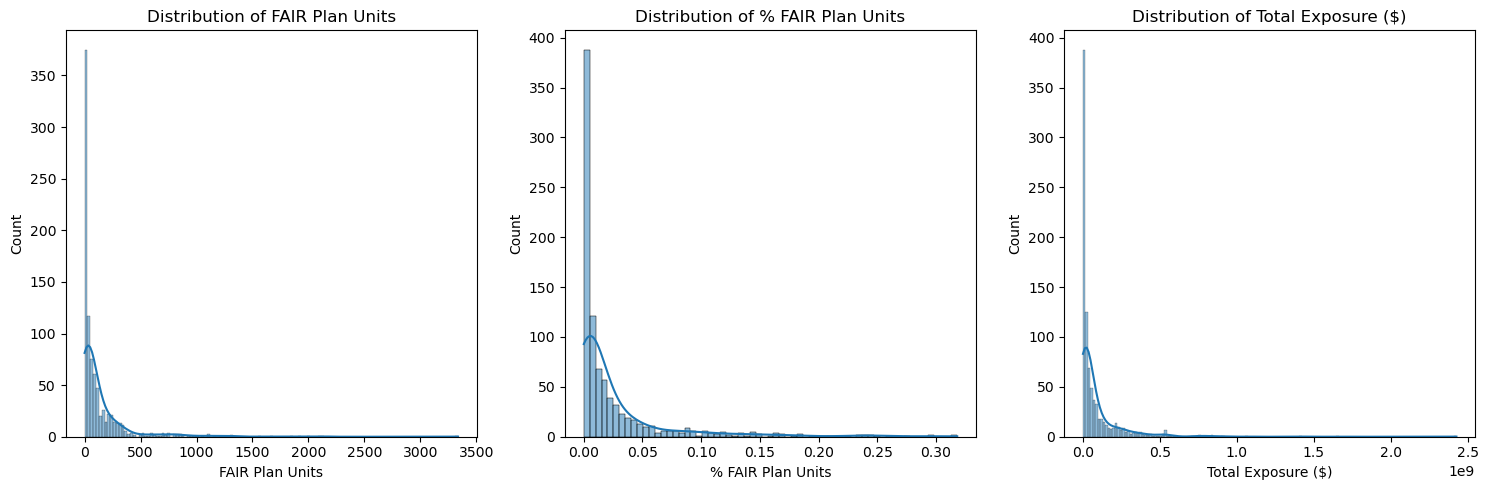

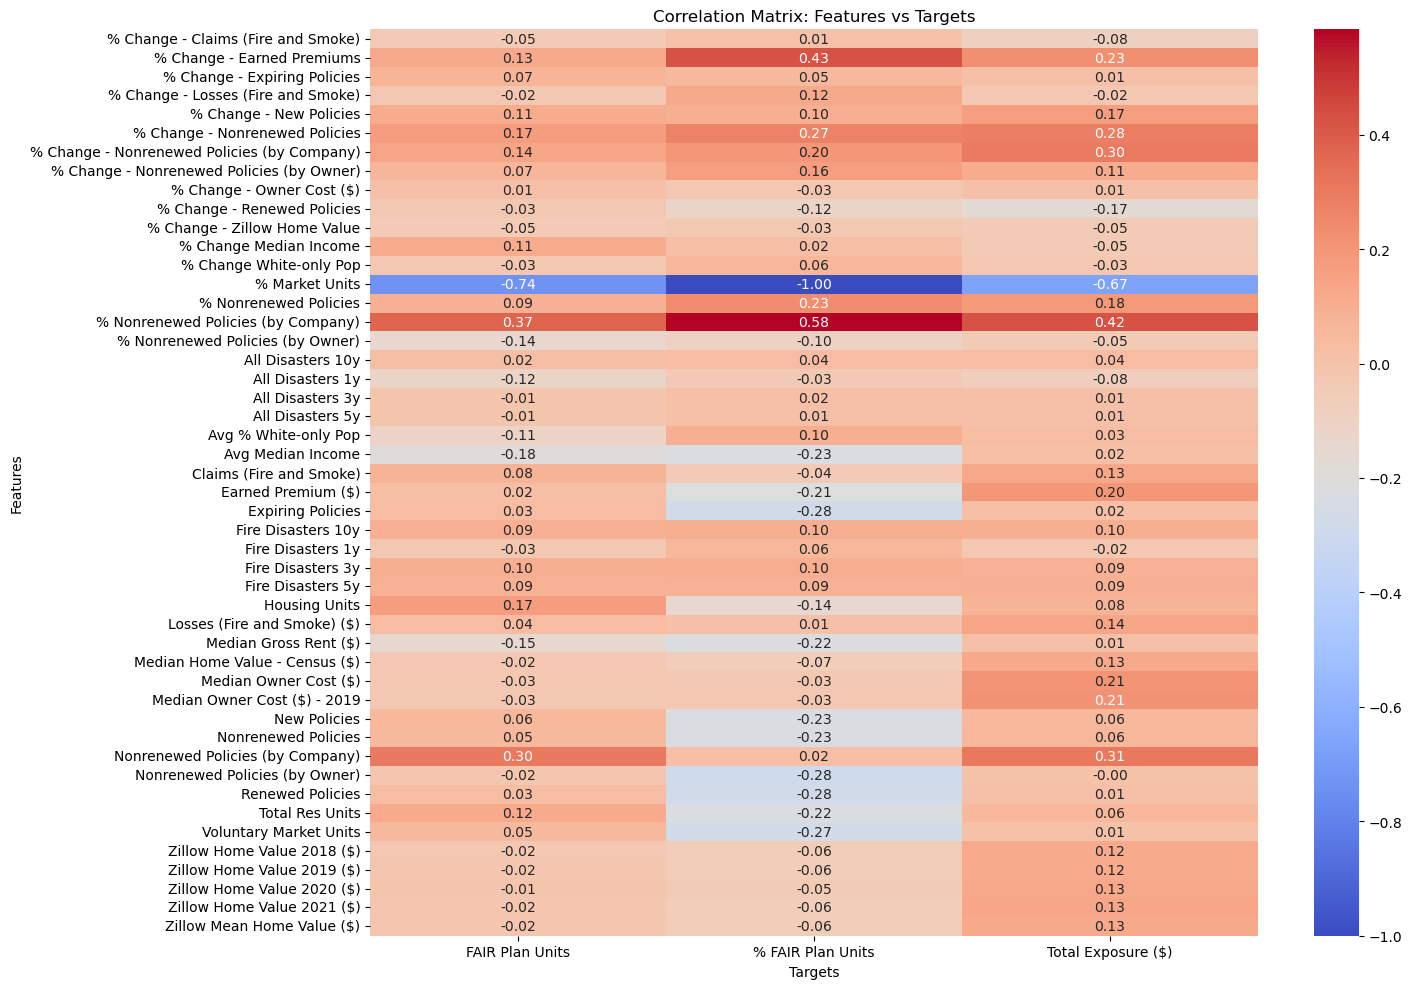

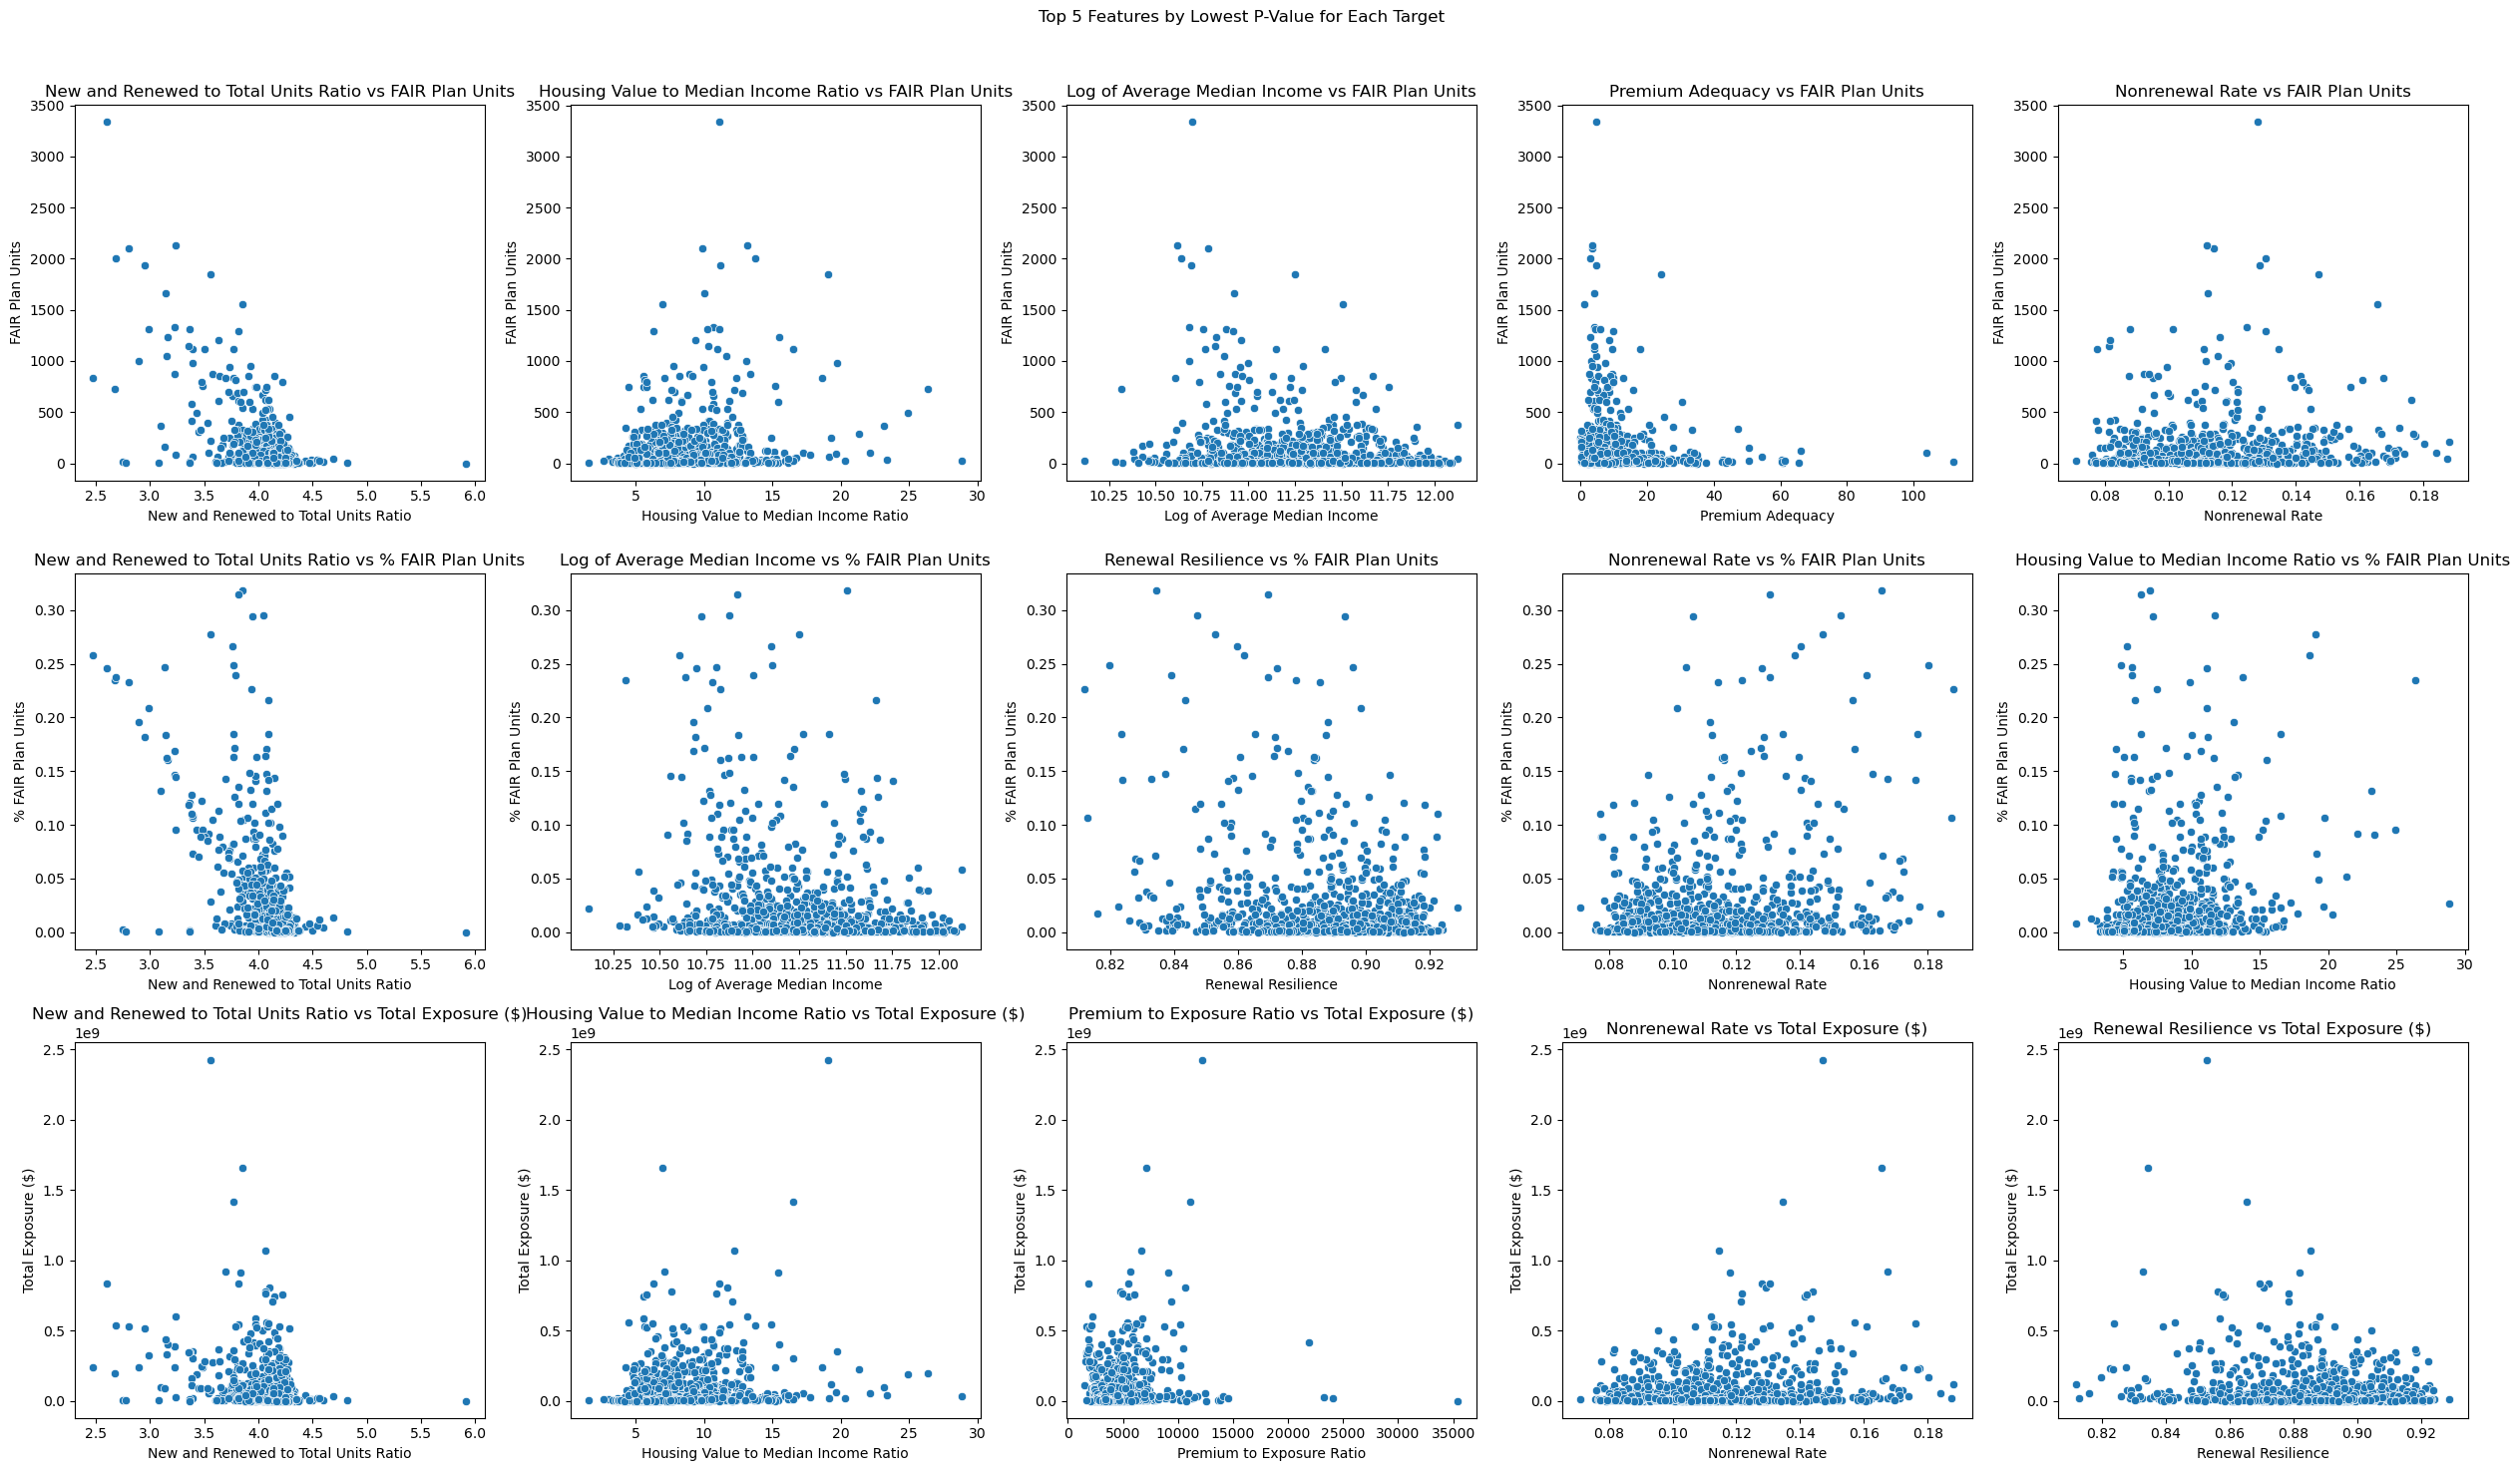

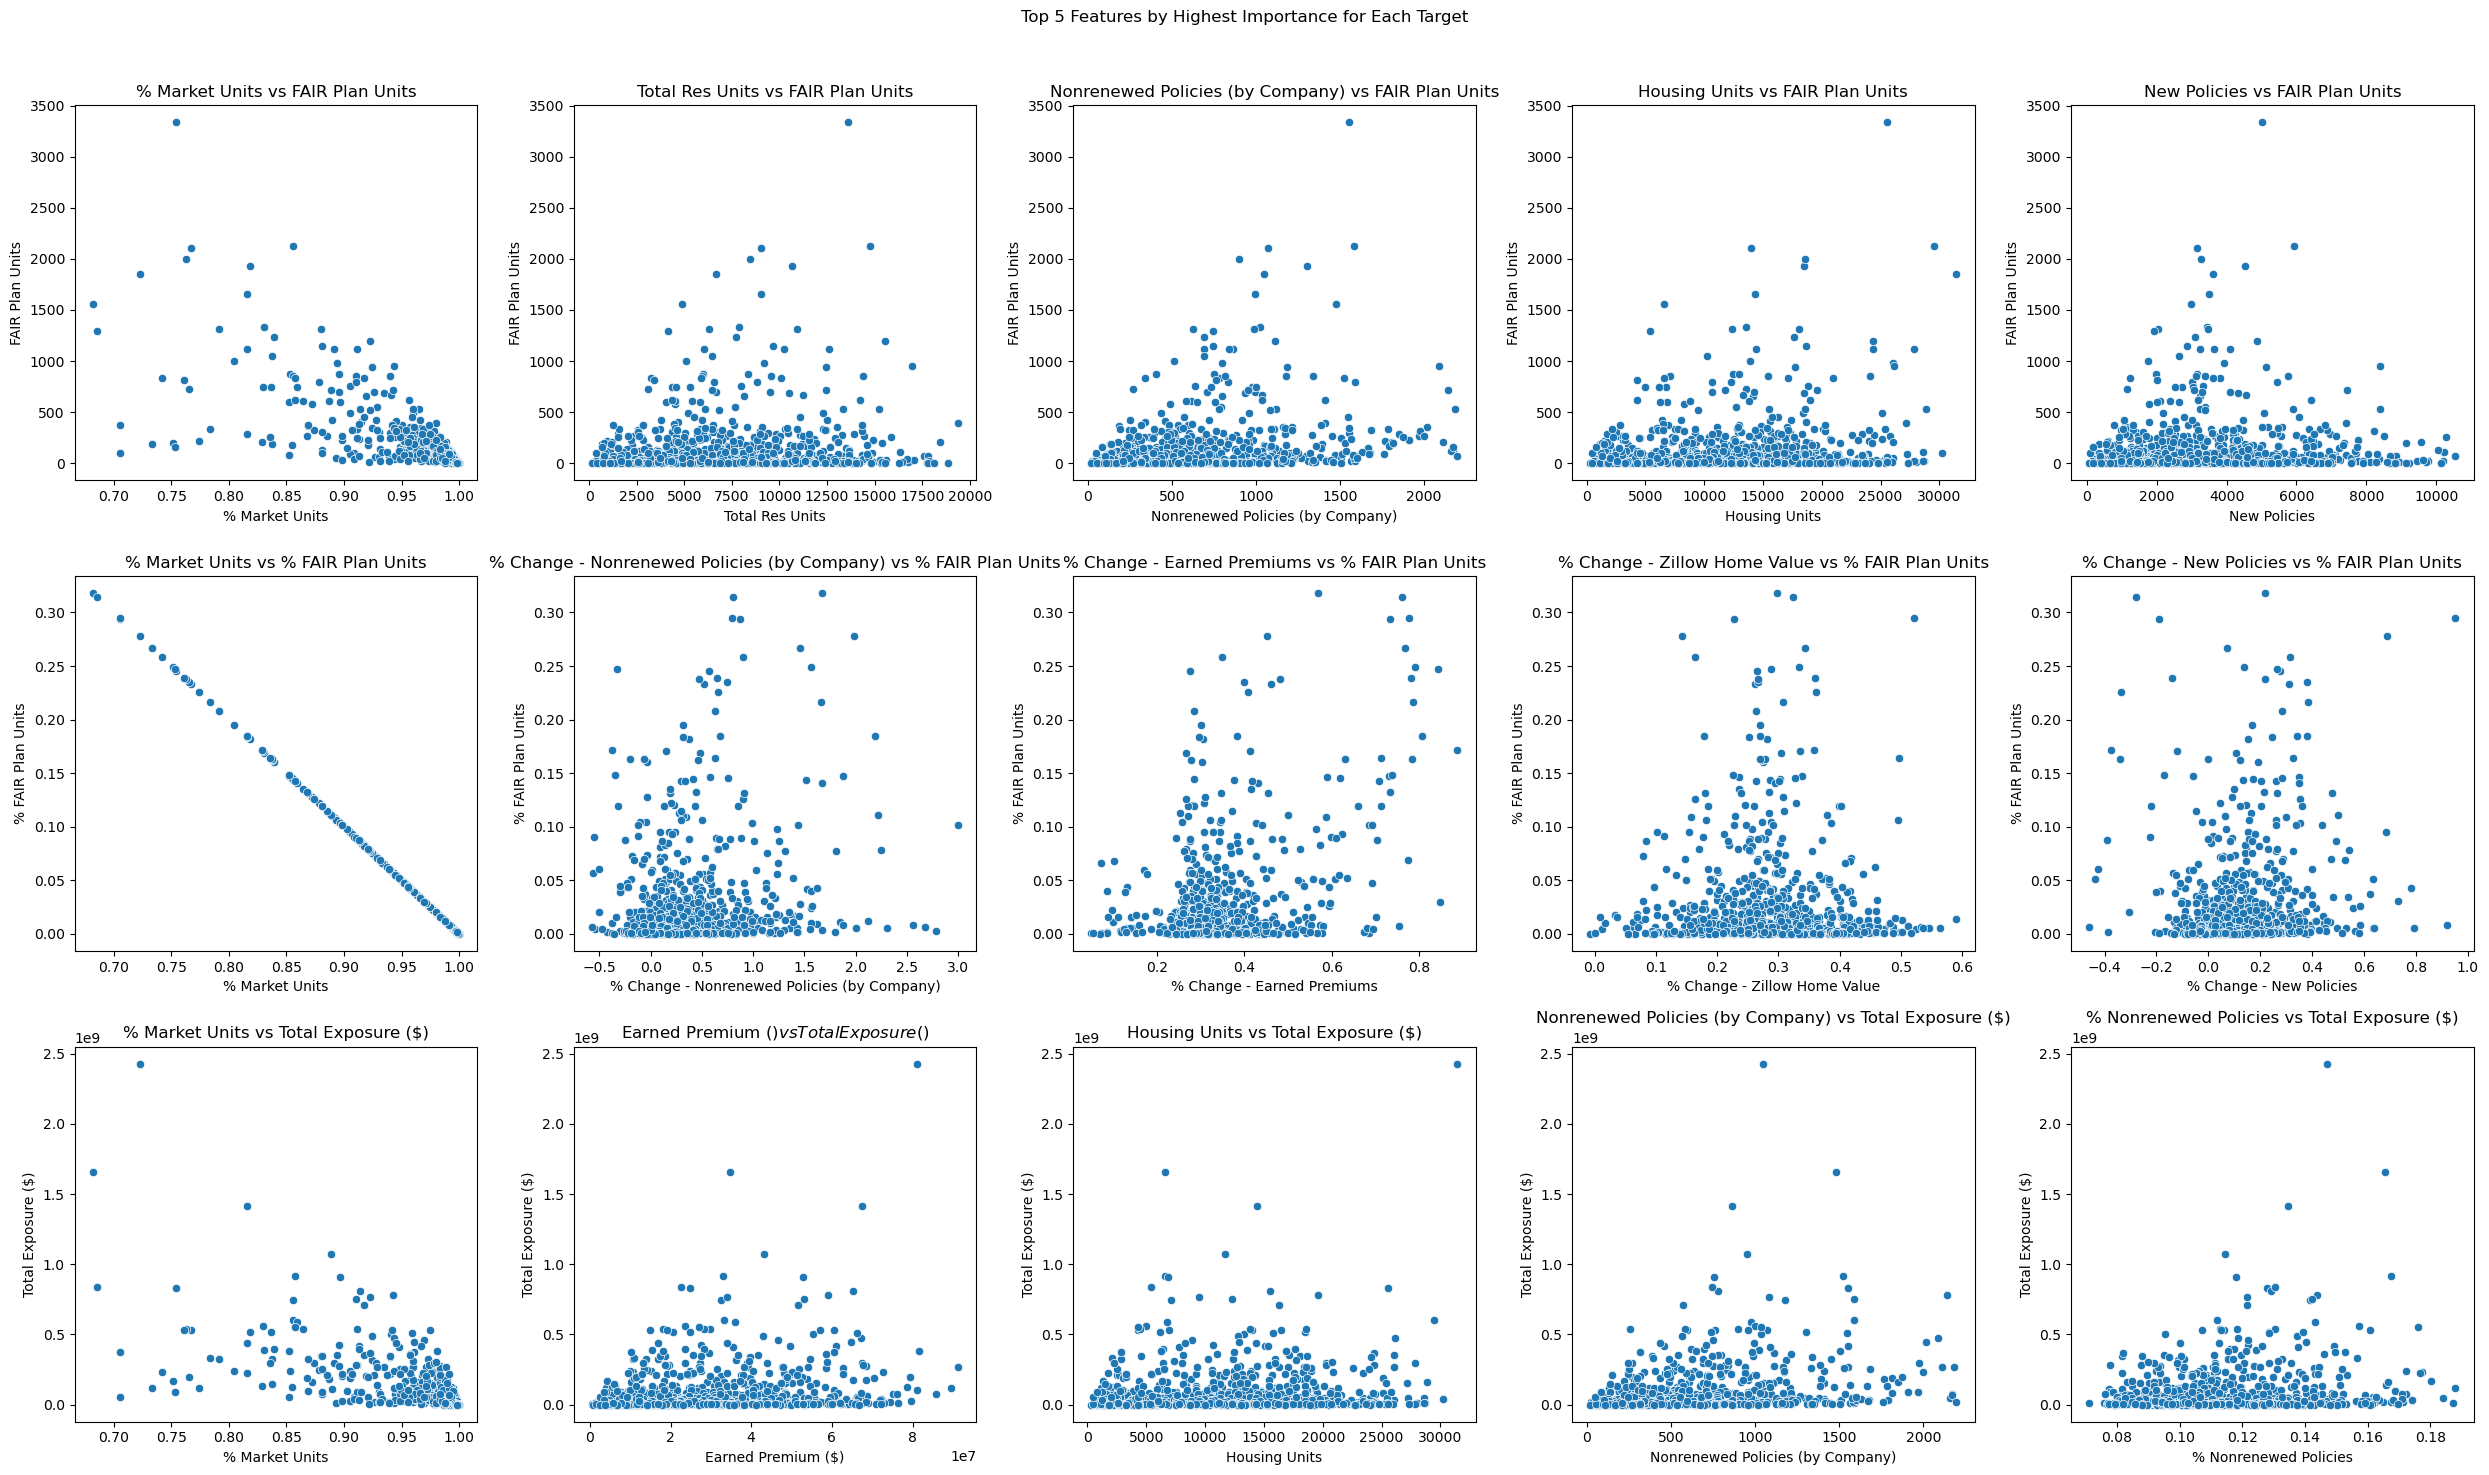

Analysis complete. Filtered results, plots, and sorted features saved to CSV files.


In [1]:
# Libraries
import pandas as pd
import numpy as np
from pathlib import Path
from scipy.stats import pearsonr, zscore
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# 1
# Load data
CLEAN_DATA_DIR = Path('../clean_data/')
df = pd.read_csv(CLEAN_DATA_DIR / 'cleaned_data.csv', index_col=0)

# Define targets and features
targets = ['FAIR Plan Units', '% FAIR Plan Units', 'Total Exposure ($)']
features = df.columns.difference(targets).tolist()

# Remove outliers using z-score
df = df[(np.abs(zscore(df[features])) < 3).all(axis=1)]

# 2
# Engineered features
independent_vars_engineered = {
    "Losses to Premium Ratio": df["Losses (Fire and Smoke) ($)"] / df["Earned Premium ($)"],
    "Renewed to Nonrenewed Ratio": df["Renewed Policies"] / df["Nonrenewed Policies"],
    "New and Renewed to Nonrenewed Ratio": (df["New Policies"] + df["Renewed Policies"]) / df["Nonrenewed Policies"],
    "New and Renewed to Total Units Ratio": (df["New Policies"] + df["Renewed Policies"]) / df["Total Res Units"],
    "Log of Average Median Income": np.log(df["Avg Median Income"]),
    "Housing Value to Median Income Ratio": df["Zillow Mean Home Value ($)"] / df["Avg Median Income"],
    "Housing Value to Log Median Income Ratio": df["Zillow Mean Home Value ($)"] / np.log(df["Avg Median Income"]),
    "Fire Smoke Claims to Total Units Ratio": df["Claims (Fire and Smoke)"] / df["Total Res Units"],
    "New and Renewed to Nonrenewed and Income Growth Product": ((df["New Policies"] + df["Renewed Policies"]) / df["Nonrenewed Policies"]) * df["% Change Median Income"],
    "New and Renewed to Nonrenewed and Income Growth Ratio": ((df["New Policies"] + df["Renewed Policies"]) / df["Nonrenewed Policies"]) / df["% Change Median Income"],
    "Losses to Company Nonrenewed Ratio": df["Losses (Fire and Smoke) ($)"] / df["Nonrenewed Policies (by Company)"],
    "Losses to Owner Nonrenewed Ratio": df["Losses (Fire and Smoke) ($)"] / df["Nonrenewed Policies (by Owner)"],
    "Change in Renewed to Income Growth Ratio": df["% Change - Renewed Policies"] / df["% Change Median Income"],
    "Change in Nonrenewed to Income Growth Ratio": (df["% Change - Nonrenewed Policies (by Owner)"] + df["% Change - Nonrenewed Policies (by Company)"]) / df["% Change Median Income"],
    "Growth in Losses to All Disasters 3yr Ratio": df["% Change - Losses (Fire and Smoke)"] / df["All Disasters 3y"],
    "Growth in Losses to All Disasters 5yr Ratio": df["% Change - Losses (Fire and Smoke)"] / df["All Disasters 5y"],
    "Growth in Losses to All Disasters 10yr Ratio": df["% Change - Losses (Fire and Smoke)"] / df["All Disasters 10y"],
    "Growth in Losses to Fire Disasters 3yr Ratio": df["% Change - Losses (Fire and Smoke)"] / df["Fire Disasters 3y"],
    "Growth in Losses to Fire Disasters 5yr Ratio": df["% Change - Losses (Fire and Smoke)"] / df["Fire Disasters 5y"],
    "Growth in Losses to Fire Disasters 10yr Ratio": df["% Change - Losses (Fire and Smoke)"] / df["Fire Disasters 10y"],
    "Premium to Exposure Ratio": df["Earned Premium ($)"] / df["Total Res Units"],
    "Nonrenewal Rate": df["Nonrenewed Policies"] / df["Expiring Policies"],
    "Loss Burden per Unit": df["Losses (Fire and Smoke) ($)"] / df["Total Res Units"],
    "Loss Burden per Exposure": df["Losses (Fire and Smoke) ($)"] / df["Total Res Units"],
    "Premium Adequacy": df["Earned Premium ($)"] / df["Losses (Fire and Smoke) ($)"],
    "Renewal Resilience": df["Renewed Policies"] / (df["Renewed Policies"] + df["Nonrenewed Policies"]),
}

# Add engineered features to the dataframe
for name, series in independent_vars_engineered.items():
    df[name] = series

# 3
# Correlation analysis
corrs = []
for name in independent_vars_engineered.keys():
    try:
        corrs.append([
            name,
            *pearsonr(df[targets[0]], df[name]),
            *pearsonr(df[targets[1]], df[name]),
            *pearsonr(df[targets[2]], df[name])
        ])
    except Exception:
        continue

corrs_df = pd.DataFrame(corrs, columns=[
    "Feature", "Corr (FAIR)", "P (FAIR)",
    "Corr (% FAIR)", "P (% FAIR)",
    "Corr (Exposure)", "P (Exposure)"
])

# 4
# Feature importance
df_train, df_test = train_test_split(df, test_size=0.2, random_state=13348)
forest1 = RandomForestRegressor(n_estimators=500, max_depth=5).fit(df_train[features], df_train[targets[0]])
forest2 = RandomForestRegressor(n_estimators=500, max_depth=5).fit(df_train[features], df_train[targets[1]])
forest3 = RandomForestRegressor(n_estimators=500, max_depth=5).fit(df_train[features], df_train[targets[2]])

importance_df = pd.DataFrame({
    "Feature": features,
    "Importance (FAIR)": forest1.feature_importances_,
    "Importance (% FAIR)": forest2.feature_importances_,
    "Importance (Exposure)": forest3.feature_importances_
})

# 5
# Filter features based on substring overlap
def filter_by_dependency(df_sorted):
    selected = []
    for feat in df_sorted["Feature"]:
        if not any(feat in s and feat != s for s in selected):
            selected.append(feat)
    return df_sorted[df_sorted["Feature"].isin(selected)]

# Apply filtering
filtered_corrs_fair = filter_by_dependency(corrs_df.sort_values("P (FAIR)"))[["Feature", "P (FAIR)"]]
filtered_corrs_percent_fair = filter_by_dependency(corrs_df.sort_values("P (% FAIR)"))[["Feature", "P (% FAIR)"]]
filtered_corrs_exposure = filter_by_dependency(corrs_df.sort_values("P (Exposure)"))[["Feature", "P (Exposure)"]]

filtered_importance_fair = filter_by_dependency(importance_df.sort_values("Importance (FAIR)", ascending=False))[["Feature", "Importance (FAIR)"]]
filtered_importance_percent_fair = filter_by_dependency(importance_df.sort_values("Importance (% FAIR)", ascending=False))[["Feature", "Importance (% FAIR)"]]
filtered_importance_exposure = filter_by_dependency(importance_df.sort_values("Importance (Exposure)", ascending=False))[["Feature", "Importance (Exposure)"]]

# Save filtered results
filtered_corrs_fair.to_csv("correlation_results_filtered_fair.csv", index=False)
filtered_corrs_percent_fair.to_csv("correlation_results_filtered_percent_fair.csv", index=False)
filtered_corrs_exposure.to_csv("correlation_results_filtered_exposure.csv", index=False)

filtered_importance_fair.to_csv("feature_importance_filtered_fair.csv", index=False)
filtered_importance_percent_fair.to_csv("feature_importance_filtered_percent_fair.csv", index=False)
filtered_importance_exposure.to_csv("feature_importance_filtered_exposure.csv", index=False)

# 6
# Generate sorted feature lists with data
def generate_sorted_features_csv(df_sorted, target_name):
    sorted_features = df_sorted["Feature"].tolist()
    sorted_features_df = df[sorted_features].copy()
    sorted_features_df.insert(0, "ZIP Code", df.index)
    sorted_features_df.to_csv(f"sorted_features_{target_name}.csv", index=False)

generate_sorted_features_csv(filtered_corrs_fair, "fair_p_value")
generate_sorted_features_csv(filtered_corrs_percent_fair, "percent_fair_p_value")
generate_sorted_features_csv(filtered_corrs_exposure, "exposure_p_value")
generate_sorted_features_csv(filtered_importance_fair, "fair_importance")
generate_sorted_features_csv(filtered_importance_percent_fair, "percent_fair_importance")
generate_sorted_features_csv(filtered_importance_exposure, "exposure_importance")

# 7
# Plot distribution of each target variable
plt.figure(figsize=(15, 5))
for i, target in enumerate(targets):
    plt.subplot(1, 3, i + 1)
    sns.histplot(df[target], kde=True)
    plt.title(f'Distribution of {target}')
plt.tight_layout()
plt.savefig('target_distributions.png')
plt.show()

# Correlation matrix heatmap
plt.figure(figsize=(15, 10))
corr_matrix = df[features + targets].corr().loc[features, targets]
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix: Features vs Targets')
plt.xlabel('Targets')
plt.ylabel('Features')
plt.tight_layout()
plt.savefig('correlation_matrix_features_vs_targets.png')
plt.show()

# Define the target and importance column maps
target_column_map = {
    'FAIR Plan Units': 'P (FAIR)',
    '% FAIR Plan Units': 'P (% FAIR)',
    'Total Exposure ($)': 'P (Exposure)'
}

importance_column_map = {
    'FAIR Plan Units': 'Importance (FAIR)',
    '% FAIR Plan Units': 'Importance (% FAIR)',
    'Total Exposure ($)': 'Importance (Exposure)'
}

# Plot top 5 features by lowest p-value for each target
fig, axes = plt.subplots(3, 5, figsize=(25, 15))
fig.suptitle('Top 5 Features by Lowest P-Value for Each Target')
for i, target in enumerate(targets):
    top_p_value_features = corrs_df.sort_values(target_column_map[target]).head(5)['Feature']
    for j, feature in enumerate(top_p_value_features):
        sns.scatterplot(ax=axes[i, j], x=df[feature], y=df[target])
        axes[i, j].set_title(f'{feature} vs {target}')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('top_5_lowest_p_value_features.png')
plt.show()

# Plot top 5 features by highest importance for each target
fig, axes = plt.subplots(3, 5, figsize=(25, 15))
fig.suptitle('Top 5 Features by Highest Importance for Each Target')
for i, target in enumerate(targets):
    top_importance_features = importance_df.sort_values(importance_column_map[target], ascending=False).head(5)['Feature']
    for j, feature in enumerate(top_importance_features):
        sns.scatterplot(ax=axes[i, j], x=df[feature], y=df[target])
        axes[i, j].set_title(f'{feature} vs {target}')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('top_5_highest_importance_features.png')
plt.show()

print("Analysis complete. Filtered results, plots, and sorted features saved to CSV files.")


## Ambiguous Variables

Sometimes different data sources provide information about similar features. Here we explore some of the repeated features to decide what we should use in the project. 

#### House Value vs. ZHPI

US Census Bureau provides data for Median Home Value (for households with the homeowner living in it) as well as Zillow publishes a (Zillow Housing Price Index)[https://www.zillow.com/research/data/] which provides a typical values for a home in specific region.

As the graph below shows, they are closely correlated as expected. However, census data is capped at $2,000,001, which skewes the data, hence ZHVI is a preferable feature. 

#### Housing Units vs. Total Residential Units

Another issue is to have a reliable estimate for the total of residential units in a given zipcode, either to calculate the percentage of FAIR Plan coverage or to include that in the model as a control variable. Here we compare data from the census with the "Total Residental Units" measure provided in the 2022 FAIR Plan data.

Based on the plot below, there seems to be a strong correlation betwen the datasets *in the upper bound the FAIR Plan data*. That means that the FAIR Plan dataset rarely gives higher values than the census data, but the opposite is not necessarily true. Considering the description of the datasets, it seems that FAIR Plan data doesn't include residential units under corporate policies--that is, corporate-owner properties like multi-unit apartment complexes.

We have only "Total Residential Units" for 2022, and "Housing Units" from the census doesn't seem to be an adequate proxy for that.

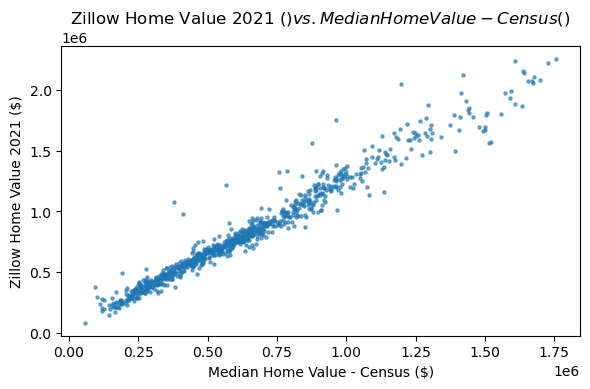

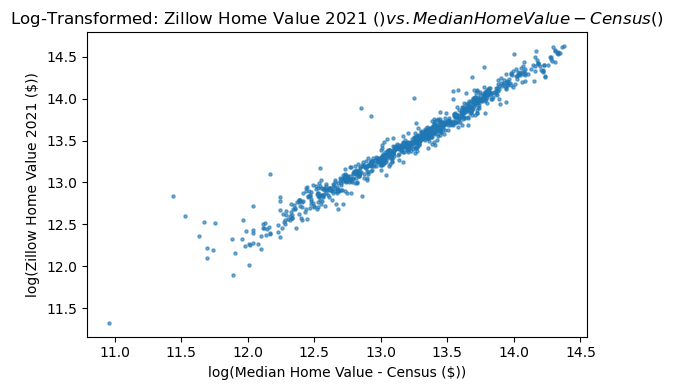


Summary of absolute differences between 'Median Home Value - Census ($)' and 'Zillow Home Value 2021 ($)':
count       904.000000
mean     179241.262758
std      105551.819653
min         741.717900
25%      116384.109950
50%      155359.592650
75%      208152.196000
max      849042.189000
dtype: float64


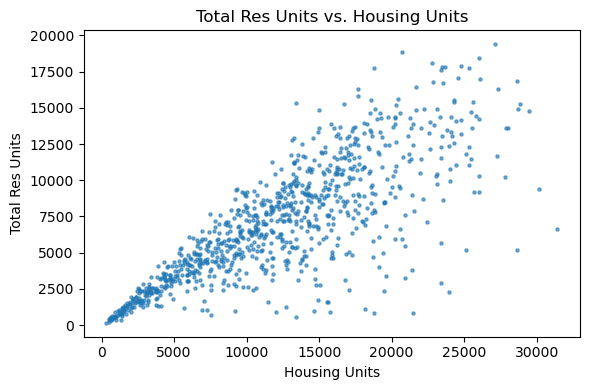

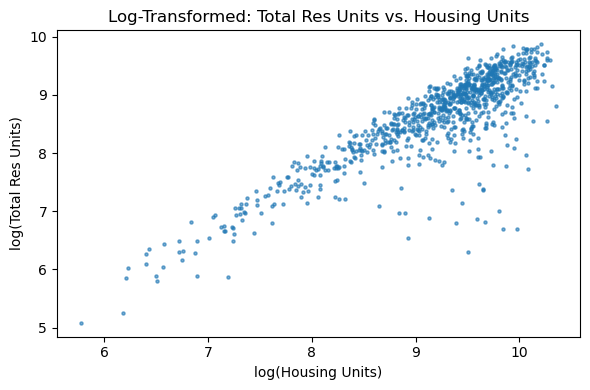


Summary of absolute differences between 'Housing Units' and 'Total Res Units':
count      904.000000
mean      5127.188053
std       4117.637928
min          9.000000
25%       1857.750000
50%       4254.500000
75%       7156.250000
max      24764.000000
dtype: float64


In [2]:
# Define ambiguous or potentially redundant variable pairs
ambiguous_pairs = [
    ('Median Home Value - Census ($)', 'Zillow Home Value 2021 ($)'),
    ('Housing Units', 'Total Res Units')
]

# Iterate over each pair and generate plots and stats
for x_var, y_var in ambiguous_pairs:
    # Raw scatter plot
    plt.figure(figsize=(6, 4))
    plt.scatter(df[x_var], df[y_var], s=5, alpha=0.6)
    plt.xlabel(x_var)
    plt.ylabel(y_var)
    plt.title(f'{y_var} vs. {x_var}', fontsize=12)
    plt.tight_layout()
    plt.savefig(f"{y_var.replace(' ', '_').replace('($)', '').replace('/', '')}_vs_{x_var.replace(' ', '_').replace('($)', '').replace('/', '')}.png")
    plt.show()

    # Log-transformed scatter plot if values are positive
    if (df[x_var] > 0).all() and (df[y_var] > 0).all():
        plt.figure(figsize=(6, 4))
        plt.scatter(np.log(df[x_var]), np.log(df[y_var]), s=5, alpha=0.6)
        plt.xlabel(f'log({x_var})')
        plt.ylabel(f'log({y_var})')
        plt.title(f'Log-Transformed: {y_var} vs. {x_var}', fontsize=12)
        plt.tight_layout()
        plt.savefig(f"Log_Transformed_{y_var.replace(' ', '_').replace('($)', '').replace('/', '')}_vs_{x_var.replace(' ', '_').replace('($)', '').replace('/', '')}.png")
        plt.show()

    # Print summary statistics of the absolute difference
    diff = abs(df[x_var] - df[y_var])
    print(f"\nSummary of absolute differences between '{x_var}' and '{y_var}':")
    print(diff.describe())
